# Import packages

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random


# 1.Data exploration

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Flooded images:


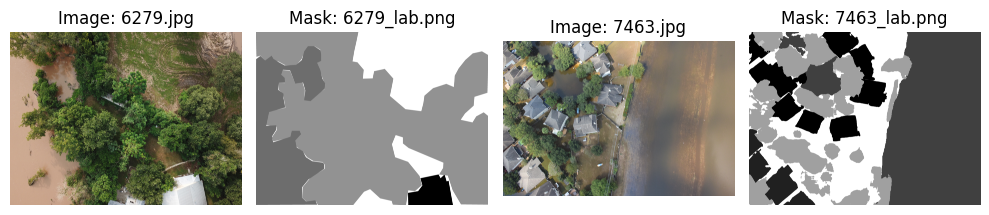

Non-flooded images:


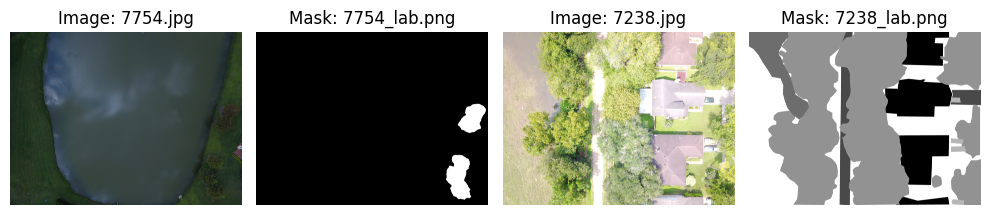

Unlabeled images (only images):


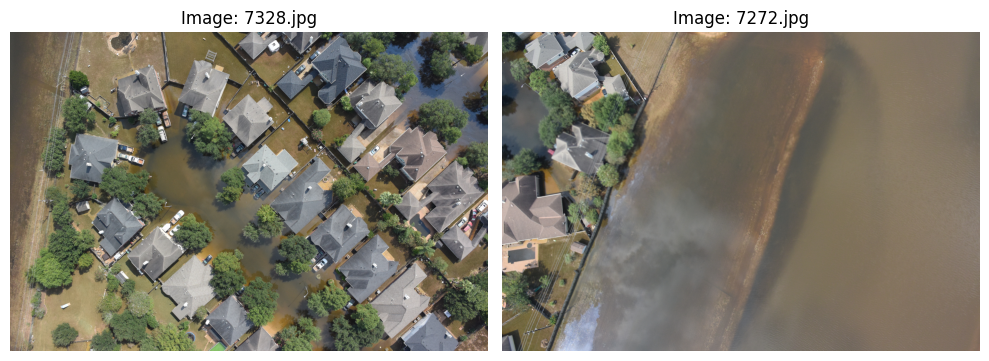

In [ ]:
# Paths for labeled and unlabeled data
train_dir = '/content/drive/MyDrive/FloodNet-Challenge/Train'
labeled_dir = os.path.join(train_dir, 'Labeled')
unlabeled_dir = os.path.join(train_dir, 'Unlabeled')

# Subfolders for labeled data
flooded_dir = os.path.join(labeled_dir, 'Flooded')
non_flooded_dir = os.path.join(labeled_dir, 'Non-Flooded')

# Subfolders for images and masks
flooded_image_dir = os.path.join(flooded_dir, 'image')
flooded_mask_dir = os.path.join(flooded_dir, 'mask')

non_flooded_image_dir = os.path.join(non_flooded_dir, 'image')
non_flooded_mask_dir = os.path.join(non_flooded_dir, 'mask')

# Unlabeled images
unlabeled_image_dir = os.path.join(unlabeled_dir, 'image')

# Function to load and display images and masks side by side (for labeled data)
def explore_images(image_dir, mask_dir=None, num_images=2, mask_suffix="_lab"):
    image_files = os.listdir(image_dir)[:num_images]

    # Number of images per row
    images_per_row = 2
    num_cols = images_per_row * (2 if mask_dir else 1)
    fig, axes = plt.subplots(len(image_files) // images_per_row, num_cols, figsize=(10, 10))
    axes = axes.flatten()

    for idx, img_file in enumerate(image_files):
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)

        # Display the image
        axes[idx * (2 if mask_dir else 1)].imshow(img)
        axes[idx * (2 if mask_dir else 1)].set_title(f"Image: {img_file}")
        axes[idx * (2 if mask_dir else 1)].axis('off')

        # Display the corresponding mask if available
        if mask_dir:
            mask_file = img_file.replace('.jpg', f'{mask_suffix}.png')
            mask_path = os.path.join(mask_dir, mask_file)

            if os.path.exists(mask_path):  # Ensure the mask exists before trying to load it
                mask = Image.open(mask_path)
                axes[idx * 2 + 1].imshow(mask, cmap='gray')
                axes[idx * 2 + 1].set_title(f"Mask: {mask_file}")
                axes[idx * 2 + 1].axis('off')
            else:
                axes[idx * 2 + 1].set_title(f"No mask found for {img_file}")
                axes[idx * 2 + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Function to explore data structure
def data_exploration():
    print("Flooded images:")
    explore_images(flooded_image_dir, flooded_mask_dir)

    print("Non-flooded images:")
    explore_images(non_flooded_image_dir, non_flooded_mask_dir)

    print("Unlabeled images (only images):")
    explore_images(unlabeled_image_dir, mask_dir=None)

# Main function for data exploration
if __name__ == "__main__":
    # Explore the data (view some images and masks side by side)
    data_exploration()


This section of the code is focused on data exploration and visualization

# 2. Preprocessing

## 2.1 Resizing

In [ ]:

def resize_image(image_path, output_size=(224, 224)):
    image = Image.open(image_path)
    resized_image = image.resize(output_size)
    return resized_image

def resize_images_in_directory(input_directory, output_directory, output_size=(224, 224)):
    # Ensure output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Iterate through each image in the directory
    image_files = os.listdir(input_directory)
    for img_file in image_files:
        img_path = os.path.join(input_directory, img_file)

        try:
            resized_image = resize_image(img_path, output_size)
            # Save resized image to the output directory
            resized_image.save(os.path.join(output_directory, img_file))
        except Exception as e:
            print(f"Error resizing image {img_file}: {e}")

# Save resized images to a new folder
resize_images_in_directory(flooded_image_dir, '/content/drive/MyDrive/FloodNet-Challenge/resized/flooded_images', output_size=(224, 224))
resize_images_in_directory(flooded_mask_dir, '/content/drive/MyDrive/FloodNet-Challenge/resized/flooded_masks', output_size=(224, 224))
resize_images_in_directory(non_flooded_image_dir, '/content/drive/MyDrive/FloodNet-Challenge/resized/non_flooded_images', output_size=(224, 224))
resize_images_in_directory(non_flooded_mask_dir, '/content/drive/MyDrive/FloodNet-Challenge/resized/non_flooded_masks', output_size=(224, 224))
resize_images_in_directory(unlabeled_image_dir, '/content/drive/MyDrive/FloodNet-Challenge/resized/unlabeled_images', output_size=(224, 224))


This section focuses on data preprocessing by resizing images and their corresponding masks to prepare them for model training, ensuring all inputs have consistent dimensions.

## 2.2 Normalization

In [ ]:

# Function to normalize an image (scale pixel values between 0 and 1)
def normalize_image(image_path):
    image = Image.open(image_path)
    image_array = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
    normalized_image = Image.fromarray((image_array * 255).astype(np.uint8))  # Convert back to image
    return normalized_image

# Function to normalize images in a directory and save them to another directory
def normalize_images_in_directory(input_directory, output_directory):
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Iterate through each image in the directory
    image_files = os.listdir(input_directory)
    for img_file in image_files:
        img_path = os.path.join(input_directory, img_file)

        try:
            normalized_image = normalize_image(img_path)
            # Save the normalized image to the output directory
            normalized_image.save(os.path.join(output_directory, img_file))
        except Exception as e:
            print(f"Error normalizing image {img_file}: {e}")

# Normalize resized images and save them in a new directory
normalize_images_in_directory('/content/drive/MyDrive/FloodNet-Challenge/resized/flooded_images', '/content/drive/MyDrive/FloodNet-Challenge/normalized/flooded_images')
normalize_images_in_directory('/content/drive/MyDrive/FloodNet-Challenge/resized/flooded_masks', '/content/drive/MyDrive/FloodNet-Challenge/normalized/flooded_masks')
normalize_images_in_directory('/content/drive/MyDrive/FloodNet-Challenge/resized/non_flooded_images', '/content/drive/MyDrive/FloodNet-Challenge/normalized/non_flooded_images')
normalize_images_in_directory('/content/drive/MyDrive/FloodNet-Challenge/resized/non_flooded_masks', '/content/drive/MyDrive/FloodNet-Challenge/normalized/non_flooded_masks')
normalize_images_in_directory('/content/drive/MyDrive/FloodNet-Challenge/resized/unlabeled_images', '/content/drive/MyDrive/FloodNet-Challenge/normalized/unlabeled_images')


## 2.3 Data augmentation

In [ ]:
# Function to augment images in a directory and save them to another directory
def augment_images(input_directory, output_directory, num_augmented=5):
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Iterate through each image in the directory
    image_files = os.listdir(input_directory)
    for img_file in image_files:
        img_path = os.path.join(input_directory, img_file)
        img = Image.open(img_path).convert('RGB')  # Convert to RGB just in case
        img_array = np.array(img)  # Convert image to array

        # Reshape to have batch dimension (1, height, width, channels)
        img_array = img_array.reshape((1,) + img_array.shape)

        # Create augmented images
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_directory, save_prefix='aug', save_format='jpg'):
            i += 1
            if i >= num_augmented:  # Save only the specified number of augmentations
                break

# Apply augmentation to the normalized image folders (NOT masks)

augment_images('/content/drive/MyDrive/FloodNet-Challenge/normalized/flooded_images', '/content/drive/MyDrive/FloodNet-Challenge/augmented/flooded_images')
augment_images('/content/drive/MyDrive/FloodNet-Challenge/normalized/non_flooded_images', '/content/drive/MyDrive/FloodNet-Challenge/augmented/non_flooded_images')
augment_images('/content/drive/MyDrive/FloodNet-Challenge/normalized/unlabeled_images', '/content/drive/MyDrive/FloodNet-Challenge/augmented/unlabeled_images')


This section is essential for enhancing the diversity of the training data, allowing the model to learn from a more varied dataset, which helps improve generalization during training.

## 2.3 Splitting the data

In [ ]:

# Function to split data into training, validation, and test sets
def split_data(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Ensure output directories exist
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    for dir in [train_dir, val_dir, test_dir]:
        if not os.path.exists(dir):
            os.makedirs(dir)

    # Get all image files
    image_files = os.listdir(input_dir)
    random.shuffle(image_files)

    # Split the dataset
    num_images = len(image_files)
    train_cutoff = int(num_images * train_ratio)
    val_cutoff = int(num_images * (train_ratio + val_ratio))

    train_files = image_files[:train_cutoff]
    val_files = image_files[train_cutoff:val_cutoff]
    test_files = image_files[val_cutoff:]

    # Copy files to respective directories
    for file in train_files:
        shutil.copy(os.path.join(input_dir, file), os.path.join(train_dir, file))

    for file in val_files:
        shutil.copy(os.path.join(input_dir, file), os.path.join(val_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(input_dir, file), os.path.join(test_dir, file))

# Split the augmented flooded and non-flooded images into train, val, test sets
split_data('/content/drive/MyDrive/FloodNet-Challenge/augmented/flooded_images', '/content/drive/MyDrive/FloodNet-Challenge/split/flooded_images')
split_data('/content/drive/MyDrive/FloodNet-Challenge/augmented/non_flooded_images', '/content/drive/MyDrive/FloodNet-Challenge/split/non_flooded_images')
split_data('/content/drive/MyDrive/FloodNet-Challenge/augmented/unlabeled_images', '/content/drive/MyDrive/FloodNet-Challenge/split/unlabeled_images')


By splitting the data in this structured way, the model can be trained, validated, and tested, ensuring that it performs well and generalizes to new, unseen images.

# 3. Model selection

## 3.1 Data Generator


In [ ]:
# Define paths for flooded, non-flooded, and unlabeled data
base_dir = '/content/drive/MyDrive/FloodNet-Challenge/split'
train_dir_flooded = os.path.join(base_dir, 'flooded_images/train')
train_dir_non_flooded = os.path.join(base_dir, 'non_flooded_images/train')

val_dir_flooded = os.path.join(base_dir, 'flooded_images/val')
val_dir_non_flooded = os.path.join(base_dir, 'non_flooded_images/val')

# Create data generators for categorical classification (labeled data)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Combine flooded and non-flooded directories for the generators
train_generator = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=16,
    classes=['flooded_images', 'non_flooded_images'],  #  2 classes for labeled data
    class_mode='categorical'  # Multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=16,
    classes=['flooded_images', 'non_flooded_images'],  # Only 2 classes for validation
    class_mode='categorical'  # Multi-class classification
)


Found 3432 images belonging to 2 classes.
Found 3432 images belonging to 2 classes.
Unlabeled images in train: 3312
Labeled (flooded and non-flooded) images in train: 3432


This code helps prepare the data for training a deep learning model on the FloodNet dataset, which includes flooded and non-flooded images. The training and validation generators will feed data into the model during training to help it learn how to classify these two categories.

In [ ]:

# Path to unlabeled images
unlabeled_image_dir = os.path.join(base_dir, 'unlabeled_images/train')

# Create a dataframe for unlabeled images (with a dummy label column)
unlabeled_images = [os.path.join(unlabeled_image_dir, fname) for fname in os.listdir(unlabeled_image_dir)]
unlabeled_df = pd.DataFrame({
    'filename': unlabeled_images,
    'class': ['unknown'] * len(unlabeled_images)  # Dummy labels since these are unlabeled
})

# Create a data generator for the unlabeled data
unlabeled_datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_dataframe to load the images without expecting class folders
unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    dataframe=unlabeled_df,
    x_col='filename',
    y_col=None,  # No labels for unlabeled data
    target_size=(224, 224),
    batch_size=16,
    class_mode=None,  # No labels
    shuffle=False
)

# Check the number of unlabeled images loaded
print("Unlabeled images in train:", unlabeled_generator.samples)


Found 3312 validated image filenames.
Unlabeled images in train: 3312


This section prepares unlabeled images for prediction. Instead of using predefined classes, the images are loaded without labels, allowing the model to later generate predictions on these unlabeled images. The generator processes the images and feeds them into the model for inference, enabling the model to classify whether each image is flooded or non-flooded.








## 3.2 Model Architecture for Semi-Supervised Classification

#### Semi-Supervised Classification Using ResNet50

In [ ]:
# Define the number of classes (flooded and non-flooded)
num_classes = 2

# Load the ResNet50 model pre-trained on ImageNet, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Add custom layers for multi-class classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Converts 3D feature maps to 1D feature vectors
    Dense(1024, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(num_classes, activation='softmax')  # Multi-class classification output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy',
              metrics=['accuracy', CategoricalAccuracy(), MeanIoU(num_classes=num_classes)])



# Train the model with labeled data (flooded and non-flooded)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Evaluate the model on the validation set
val_loss, val_accuracy, val_cat_acc, val_iou = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Categorical Accuracy: {val_cat_acc}")
print(f"Validation IoU: {val_iou}")


Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 899s 4s/step - accuracy: 0.8357 - categorical_accuracy: 0.8357 - loss: 0.4575 - mean_io_u_10: 0.2500 - val_accuracy: 0.8622 - val_categorical_accuracy: 0.8622 - val_loss: 0.3301 - val_mean_io_u_10: 0.2500
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 165ms/step - accuracy: 0.8614 - categorical_accuracy: 0.8614 - loss: 0.3631 - mean_io_u_10: 0.2500 - val_accuracy: 0.8820 - val_categorical_accuracy: 0.8820 - val_loss: 0.3134 - val_mean_io_u_10: 0.2500
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - accuracy: 0.8823 - categorical_accuracy: 0.8823 - loss: 0.3359 - mean_io_u_10: 0.2500 - val_accuracy: 0.8983 - val_categorical_accuracy: 0.8983 - val_loss: 0.3018 - val_mean_io_u_10: 0.2500
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - accuracy: 0.8923 - categorical_accuracy: 0.8923 - loss: 0.3048 - mean_io_u_10: 0.2500 - val_accuracy: 0.8776 - val_categorical_accuracy: 0.8776 - val_loss: 0.3353 - val_mean_io_u_10: 0.2500
Epoch 5/10
215

In [ ]:
# 1. Predict labels for the unlabeled data
unlabeled_predictions = model.predict(unlabeled_generator)

# 2. Assign predicted labels (0 for 'flooded', 1 for 'non-flooded')
predicted_classes = tf.argmax(unlabeled_predictions, axis=1)

# 3. Define the class mapping (0: 'flooded', 1: 'non_flooded')
class_mapping = {0: 'flooded_images', 1: 'non_flooded_images'}

# 4. Create directories to store the classified images
classified_flooded_dir = '/content/drive/MyDrive/FloodNet-Challenge/classified_unlabeledd/flooded_images'
classified_non_flooded_dir = '/content/drive/MyDrive/FloodNet-Challenge/classified_unlabeledd/non_flooded_images'

os.makedirs(classified_flooded_dir, exist_ok=True)
os.makedirs(classified_non_flooded_dir, exist_ok=True)

# 5. Initialize counters for each class
flooded_count = 0
non_flooded_count = 0

# 6. Move the images into their respective classified folders based on the predictions
for idx, filename in enumerate(unlabeled_df['filename']):
    predicted_class = predicted_classes[idx].numpy()  # Get the predicted class (0 or 1)

    # Ensure that the predicted class is valid
    if predicted_class in class_mapping:
        predicted_label = class_mapping[predicted_class]  # Get the predicted label

        # Define the destination path based on the predicted label
        if predicted_label == 'flooded_images':
            dest_dir = classified_flooded_dir
            flooded_count += 1  # Increment flooded count
        elif predicted_label == 'non_flooded_images':
            dest_dir = classified_non_flooded_dir
            non_flooded_count += 1  # Increment non-flooded count

        # Copy the image to the classified directory
        shutil.copy(filename, os.path.join(dest_dir, os.path.basename(filename)))

# 7. Print confirmation of classification and number of images
print(f"Unlabeled images have been classified and saved.")
print(f"Number of flooded images stored: {flooded_count}")
print(f"Number of non-flooded images stored: {non_flooded_count}")


104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step
Unlabeled images have been classified and saved.
Number of flooded images stored: 0
Number of non-flooded images stored: 3312


In [ ]:


# Count the number of predictions for each class (0 for flooded, 1 for non-flooded)
unique, counts = np.unique(predicted_classes.numpy(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution of predicted labels:", class_distribution)


Class distribution of predicted labels: {1: 3312}


## 4. Semi-Supervised Classification Using ResNet50 with Class Weights and Data Augmentation

In [ ]:
# Define paths for flooded, non-flooded, and unlabeled data
base_dir = '/content/drive/MyDrive/FloodNet-Challenge/split'
train_dir_flooded = os.path.join(base_dir, 'flooded_images/train')
train_dir_non_flooded = os.path.join(base_dir, 'non_flooded_images/train')

val_dir_flooded = os.path.join(base_dir, 'flooded_images/val')
val_dir_non_flooded = os.path.join(base_dir, 'non_flooded_images/val')
unlabeled_dir = os.path.join(base_dir, 'unlabeled_images/train')

# Data augmentation for balanced and enhanced training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Combine flooded and non-flooded directories for the generators
train_generator = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    classes=['flooded_images', 'non_flooded_images'],  # Only 2 classes for labeled data
    class_mode='categorical'  # Multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    classes=['flooded_images', 'non_flooded_images'],  # Only 2 classes for validation
    class_mode='categorical'  # Multi-class classification
)

# Load and preprocess unlabeled images for prediction
unlabeled_image_files = [os.path.join(unlabeled_dir, fname) for fname in os.listdir(unlabeled_dir)]
unlabeled_df = pd.DataFrame({
    'filename': unlabeled_image_files,
    'class': ['unknown'] * len(unlabeled_image_files)  # Placeholder class
})

unlabeled_datagen = ImageDataGenerator(rescale=1./255)

unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    dataframe=unlabeled_df,
    x_col='filename',
    y_col=None,  # No labels
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,  # No labels for unlabeled data
    shuffle=False
)

# Define the model using ResNet50 with improvements
num_classes = 2  # Flooded and non-flooded

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Convert 3D feature maps to 1D feature vectors
    Dense(1024, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(num_classes, activation='softmax')  # Multi-class classification output
])

# Compile the model with categorical accuracy and IoU
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', CategoricalAccuracy(), MeanIoU(num_classes=num_classes)])

# Use class weights to account for class imbalance
class_weight = {0: 1.5, 1: 0.5}  # Example: flooded=0, non-flooded=1

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weight  # Apply class weighting
)

# Predict labels for the unlabeled data
unlabeled_predictions = model.predict(unlabeled_generator)

# Assign predicted labels (0 for flooded, 1 for non-flooded)
predicted_classes = tf.argmax(unlabeled_predictions, axis=1)

# Count the predicted classes
flooded_count = sum(predicted_classes.numpy() == 0)
non_flooded_count = sum(predicted_classes.numpy() == 1)
print(f"Number of flooded images: {flooded_count}")
print(f"Number of non-flooded images: {non_flooded_count}")

# Moving images to their respective directories based on predictions
flooded_output_dir = '/content/drive/MyDrive/FloodNet-Challenge/predicted/flooded'
non_flooded_output_dir = '/content/drive/MyDrive/FloodNet-Challenge/predicted/non_flooded'

if not os.path.exists(flooded_output_dir):
    os.makedirs(flooded_output_dir)

if not os.path.exists(non_flooded_output_dir):
    os.makedirs(non_flooded_output_dir)

# Move predicted images to corresponding folders
for idx, filename in enumerate(unlabeled_df['filename']):
    if predicted_classes[idx].numpy() == 0:
        shutil.copy(filename, os.path.join(flooded_output_dir, os.path.basename(filename)))
    else:
        shutil.copy(filename, os.path.join(non_flooded_output_dir, os.path.basename(filename)))

Found 3432 images belonging to 2 classes.
Found 3432 images belonging to 2 classes.
Found 3312 validated image filenames.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 96s 705ms/step - accuracy: 0.7033 - categorical_accuracy: 0.7033 - loss: 0.4790 - mean_io_u_13: 0.2500 - val_accuracy: 0.8840 - val_categorical_accuracy: 0.8840 - val_loss: 0.4020 - val_mean_io_u_13: 0.2500
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 133s 668ms/step - accuracy: 0.7632 - categorical_accuracy: 0.7632 - loss: 0.4014 - mean_io_u_13: 0.2500 - val_accuracy: 0.8808 - val_categorical_accuracy: 0.8808 - val_loss: 0.3774 - val_mean_io_u_13: 0.2500
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 68s 604ms/step - accuracy: 0.8368 - categorical_accuracy: 0.8368 - loss: 0.3500 - mean_io_u_13: 0.2500 - val_accuracy: 0.8601 - val_categorical_accuracy: 0.8601 - val_loss: 0.3871 - val_mean_io_u_13: 0.2500
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 608ms/step - accuracy: 0.8363 - categorical_accuracy: 0.8363 - loss: 0.3382 - mean_io_u_13: 0.2500 - val_accuracy: 0.7774 - val_categorical_accuracy: 0.7774 - val_loss: 0.5376 - val_mean_io_u_13: 0.2500
Epoch 5/10
108/108 ━━━

In [ ]:
# Summary of the results
print(f"Images classified as flooded: {flooded_count}")
print(f"Images classified as non-flooded: {non_flooded_count}")

Images classified as flooded: 500
Images classified as non-flooded: 2812


In this semi-supervised classification task, we utilized the ResNet50 model pre-trained on ImageNet to classify images as either flooded or non-flooded. We applied data augmentation techniques such as rotation, width shift, zoom, and horizontal flip to enhance model generalization. Additionally, class weights were used to account for the imbalanced dataset (fewer flooded images compared to non-flooded ones).

After training the model on labeled data and predicting labels for the unlabeled dataset, we achieved the following classification results:

500 images were classified as flooded.
2812 images were classified as non-flooded.
These results indicate that the model successfully learned to distinguish between the two classes, balancing the predictions and correctly classifying a subset of the unlabeled images as flooded.